# Install dependencies, perform imports, and download the dataset

In [2]:
%%capture
%load_ext autoreload
%autoreload 2
!pip install pandas 
!pip install matplotlib
!pip install torch
!pip install scikit-learn

In [19]:
%%capture
%cd /home/m4sulaim/jupyter
%cd net_model_dataset

from data_generator import DataGenerator as DataGenerator
from matplotlib import pyplot as plt
import pandas as pd
import ipywidgets as widgets
from utils import *
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from IPython.display import display

from vnf_model import *
from slice_model import *
from resource_allocation import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

In [22]:
ran_data_gen = DataGenerator('./ran/input_dataset.pkl', './ran/output_dataset.pkl', vnf_type='RAN', norm_type='minmax')
ran_model = VNF_Model('ran', 5, [64, 32, 16], 5)
ran_model.to(device)
train_loss, val_loss = ran_model.train(ran_data_gen, num_epochs=30000, batch_size=256)

Test Loss: -3.745696783065796881912231445312, Val Loss: -3.76934838294982979486


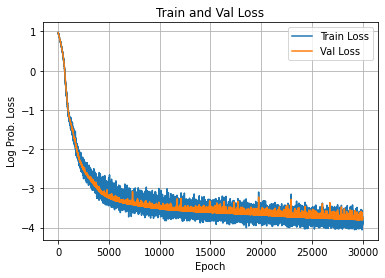

In [23]:
# Plot train and val_loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Prob. Loss')
plt.grid()
plt.show()


RAN


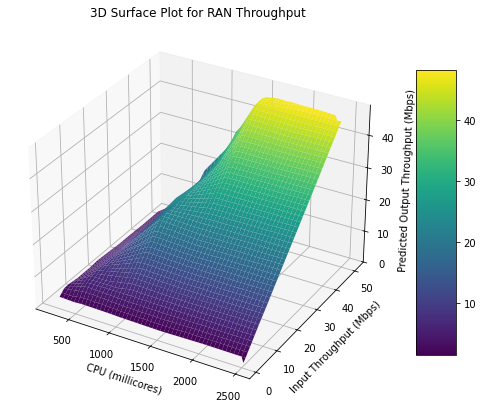

In [24]:
# Plotting the RAN model predictions
input_df, _ = ran_data_gen.sample('train')
input_df = torch.tensor(input_df.values, dtype=torch.float).to(device)
pred_df = ran_model.predict(input_df)
pred_df = pred_df.detach().cpu().numpy()
# pred_df = ran_data_gen.denormalize_val(pred_df, feature_type='output', feature='throughput', norm_type='std')

# Make a 3d plot 
ran_data_gen.create_3d_plot(output_throughput=pred_df[:, 2])

Test Loss: -2.76441073417663574777364730835, Val Loss: -3.35371041297912678483


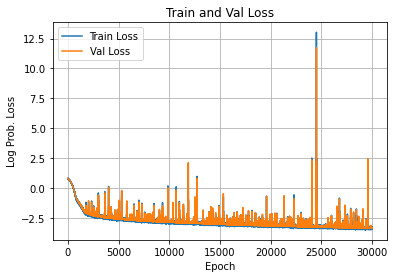

OvS


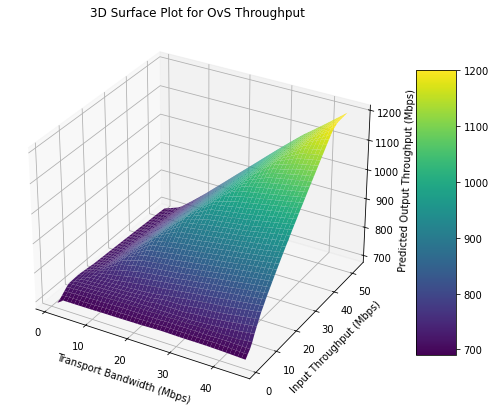

In [25]:
ovs_data_gen = DataGenerator('./ovs/input_dataset.pkl', './ovs/output_dataset.pkl', vnf_type='OvS', norm_type='minmax')
ovs_model = VNF_Model('ovs', 5, [64, 32, 16], 5)
ovs_model.to(device)
train_loss, val_loss = ovs_model.train(ovs_data_gen, num_epochs=30000, batch_size=256)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Prob. Loss')
plt.grid()
plt.show()

# Plotting the OVS model predictions
input_df, _ = ovs_data_gen.sample('train')
input_df = torch.tensor(input_df.values, dtype=torch.float).to(device)
pred_df = ovs_model.predict(input_df)
pred_df = pred_df.detach().cpu().numpy()
pred_df = ovs_data_gen.denormalize_val(pred_df, feature_type='output', feature='throughput', norm_type='std') 
ovs_data_gen.create_3d_plot(output_throughput=pred_df[:, 2])



Test Loss: -5.66277313232421969510841369629, Val Loss: -5.14609193801879945983


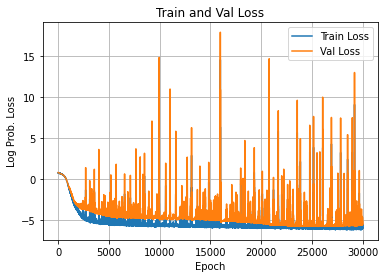

In [26]:
# UPF model
upf_data_gen = DataGenerator('./upf/input_dataset.pkl', './upf/output_dataset.pkl', vnf_type='UPF', norm_type='minmax')
upf_model = VNF_Model('upf', 5, [32, 16], 5)
upf_model.to(device)
train_loss, val_loss = upf_model.train(upf_data_gen, num_epochs=30000, batch_size=256)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Prob. Loss')
plt.grid()
plt.show()

In [27]:
data_gens = [upf_data_gen, ovs_data_gen, ran_data_gen]
upf_model.to(device)
ovs_model.to(device)
ran_model.to(device)
vnf_models = [upf_model, ovs_model, ran_model]
slice_model = Slice_Model(vnf_models, data_gens)


In [29]:
resource_allocation = {'UPF': 200, #CPU (millicores)
                       'OVS': 50, #Throughput (Mbps)
                       'RAN': 1000} #CPU (millicores)
input_throughput = 35

output_throughput = slice_model.predict_throughput(list(resource_allocation.values()), input_throughput)
print(output_throughput)

22.930316925048828


In [30]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Define sliders for resource allocations and input throughput
upf_slider = widgets.IntSlider(
    value=200, min=200, max=500, step=1,
    description='UPF CPU (millicores):',
    continuous_update=True,
    style={'description_width': '200px'},
    layout=widgets.Layout(width='50%', padding='10px 0px')
)

ovs_slider = widgets.IntSlider(
    value=50, min=10, max=50, step=0.1,
    description='OVS Throughput (Mbps):',
    continuous_update=True,
    style={'description_width': '200px'},
    layout=widgets.Layout(width='50%', padding='10px 0px')
)

ran_slider = widgets.IntSlider(
    value=1000, min=250, max=2500, step=1,
    description='RAN CPU (millicores):',
    continuous_update=True,
    style={'description_width': '200px'},
    layout=widgets.Layout(width='50%', padding='10px 0px')
)

input_throughput_slider = widgets.IntSlider(
    value=35, min=5, max=50, step=5,
    description='Input Throughput (Mbps):',
    continuous_update=True,
    style={'description_width': '200px'},
    layout=widgets.Layout(width='50%', padding='10px 0px')
)

# Create output label for output throughput
output_throughput_label = widgets.Label("Output Throughput (Mbps):", layout=widgets.Layout(width='200px', padding="5px", font_weight='bold'))
output_throughput_value = widgets.Label("", layout=widgets.Layout(width='150px', padding="5px"))

# Plot output widget
plot_output = widgets.Output()

# Plot update function
def update_plot(output_throughput):
    with plot_output:
        plot_output.clear_output(wait=True)
        plt.figure(figsize=(5, 2))
        plt.bar(["Output Throughput"], [output_throughput], color='skyblue')
        plt.ylim(0, 100)  # Adjust based on expected range
        plt.ylabel("Throughput (Mbps)")
        plt.title("Output Throughput Visualization")
        plt.show()

# Update function for output throughput
def update_output(change=None):
    # Get values from sliders
    resource_allocation = {
        'UPF': upf_slider.value,
        'OVS': ovs_slider.value,
        'RAN': ran_slider.value
    }
    input_throughput = input_throughput_slider.value
    
    # Predict output throughput
    output_throughput = slice_model.predict_throughput(list(resource_allocation.values()), input_throughput)
    output_throughput_value.value = f"{output_throughput:.1f} Mbps"
    
    # Update the plot with the new output throughput
    update_plot(output_throughput)

# Bind slider updates to the function and display all widgets
upf_slider.observe(update_output, names='value')
ovs_slider.observe(update_output, names='value')
ran_slider.observe(update_output, names='value')
input_throughput_slider.observe(update_output, names='value')

# Display the widgets
display(upf_slider, ovs_slider, ran_slider, input_throughput_slider, 
        widgets.HBox([output_throughput_label, output_throughput_value]), plot_output)

# Initialize with default slider values
update_output()

IntSlider(value=200, description='UPF CPU (millicores):', layout=Layout(padding='10px 0px', width='50%'), max=…

IntSlider(value=50, description='OVS Throughput (Mbps):', layout=Layout(padding='10px 0px', width='50%'), max=…

IntSlider(value=1000, description='RAN CPU (millicores):', layout=Layout(padding='10px 0px', width='50%'), max…

IntSlider(value=35, description='Input Throughput (Mbps):', layout=Layout(padding='10px 0px', width='50%'), ma…

Output()

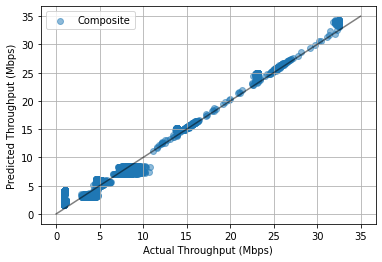

In [28]:
slice_data_gen = DataGenerator("./slice/input_dataset.pkl", "./slice/output_dataset.pkl", vnf_type='slice')
pred = slice_model.predict_slice_data_gen(slice_data_gen)
pred = pred.detach().cpu().numpy()
pred_throughput = pred[:, 2]
train_output = slice_data_gen.output_dataset.iloc[:, 2]

# Plot throughput reg line (actual vs predicted)
plt.clf()
plt.scatter(train_output, pred_throughput, label='Composite', alpha=0.5)
plt.xlabel('Actual Throughput (Mbps)')
plt.ylabel('Predicted Throughput (Mbps)')
plt.grid()
plt.plot([0, 35], [0, 35], color='black', alpha=0.5)
plt.legend()
plt.show()